In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
np.seterr(all='warn')
mpl.rcParams['figure.dpi'] = 70

import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING) 

from functools import wraps
if not hasattr(plt, 'old_subplots'): plt.old_subplots = plt.subplots
@wraps(plt.old_subplots)
def my_subplots(*args, **kwargs):
    if not 'figsize' in kwargs and len(args) > 1:
        width = 5
        maxwidth = 15
        rows, cols, *_ = args
        w = min(maxwidth, width * cols)
        kwargs['figsize'] = (w, w / cols / 1.6 * rows)
    
    gridspec_kw = dict()
    if kwargs.get('sharex') == 'col':
        gridspec_kw['hspace'] = 0.1
    if kwargs.get('sharey') == 'row':
        gridspec_kw['wspace'] = 0.1
    if 'gridspec_kw' in kwargs:
        gridspec_kw.update(kwargs['gridspec_kw'])
    kwargs['gridspec_kw'] = gridspec_kw
    
    return plt.old_subplots(*args, **kwargs)
        
plt.subplots = my_subplots

In [3]:
from disorder_model import correlated_noise
from FKMC.general import solve_H_vectorised, diag2column, spread

In [4]:
from numpy.fft import rfft, irfft, rfftfreq, hfft, ihfft, fftshift

M = int(1e4) # average over this many replications
L = 1001 # system size
x = np.arange(0,L//2 + 1,1)
print(x.shape)

gamma = 0.2
#p = np.exp(-x/100)

A, B, gamma = [0.26619629, 0.26956846, 0.62552483]
f = lambda x, A, B, gamma: A*(1+x**2)**(-gamma/2) + B
p = f(x, A, B, gamma)

power_law_noise, U, Uq, Sq, Nq = correlated_noise(p, replications = M)
alternating = 2*(np.arange(power_law_noise.shape[-1]) % 2) - 1
alternating_power_law_noise = power_law_noise * alternating

binary = 2*(power_law_noise > 0) - 1



print(f'mean(binary) = {power_law_noise.mean()}')
print(f'std(binary) = {power_law_noise.std()}')

print(f'mean(noise) = {power_law_noise.mean()}')
print(f'std(noise) = {power_law_noise.std()}')

C = np.cov(power_law_noise, rowvar = False)
R = diag2column(np.corrcoef(power_law_noise, rowvar = False))

Cb = np.cov(binary, rowvar = False)
Rb = diag2column(np.corrcoef(binary, rowvar = False))

p_current = diag2column(Cb).mean(axis = 0)[L//2]
p_target = p[L//2]
pc = 1 - (p_target - 1 + 2*p_current)/(4*p_current - 2)
print(dict(p_current =p_current, p_target = p_target, pc=pc))

a2 = np.random.choice((1,-1), p=(pc, 1-pc), size = power_law_noise.shape)
binary2 = binary*a2

Cb2 = diag2column(np.cov(binary2, rowvar = False))
Rb2 = diag2column(np.corrcoef(binary2, rowvar = False))

(501,)
mean(binary) = -0.002881347697613807
std(binary) = 0.7336525265739262
mean(noise) = -0.002881347697613807
std(noise) = 0.7336525265739262
{'p_current': 0.3437167255125505, 'p_target': 0.2750251427143654, 'pc': 0.9399465387712548}


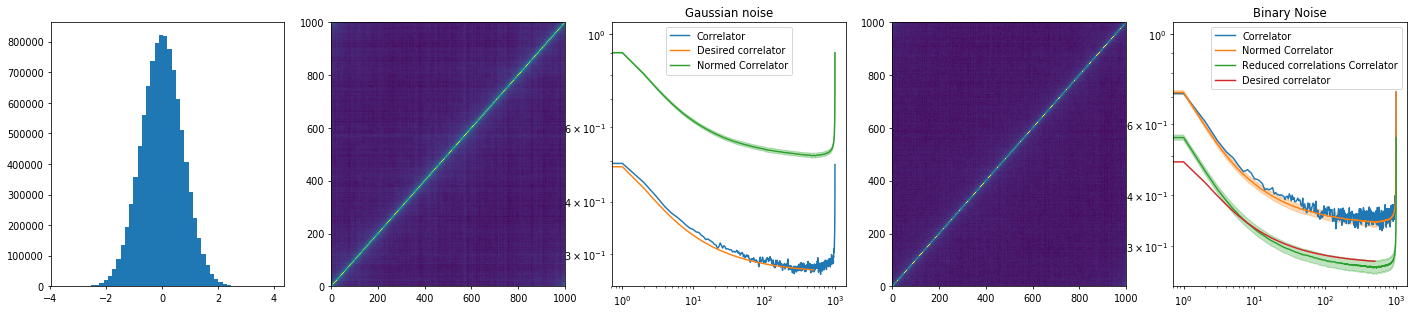

In [5]:
f, axes = plt.subplots(1,5, figsize = (25,5))   
    
axes[0].hist(power_law_noise.flatten(), bins = 50)

axes[1].pcolormesh(C.T)

axes[2].set(title = 'Gaussian noise')
axes[2].loglog(C[0, : ], label = 'Correlator')
axes[2].plot(p[:], label = 'Desired correlator')
spread(axes[2], range(R.shape[0]), R.mean(axis = 0), R.std(axis = 0), label = 'Normed Correlator')

axes[3].pcolormesh(Cb.T)

axes[4].set(title = 'Binary Noise', yscale = 'log', xscale = 'log')
axes[4].plot(Cb[0, : ], label = 'Correlator')
spread(axes[4], range(Rb.shape[0]), Rb.mean(axis = 0), Rb.std(axis = 0), label = 'Normed Correlator')
spread(axes[4], range(Cb2.shape[0]), Cb2.mean(axis = 0), Cb2.std(axis = 0), label = 'Reduced correlations Correlator')

axes[4].plot(p[:], label = 'Desired correlator')


axes[2].legend()
axes[4].legend()

In [6]:
%%time
from munch import Munch
from FKMC.general import interaction_matrix

M = int(1) # average over this many replications
N = 5000 # system size
x = np.arange(0,N//2 + 1,1)
print(x.shape)

gamma = 0.2
p = 5 * (1 + x**2)**(-gamma/2)

power_law_noise, U, Uq, Sq, Nq = correlated_noise(p, replications = M)
alternating = 2*(np.arange(power_law_noise.shape[-1]) % 2) - 1
alternating_power_law_noise = power_law_noise * alternating

states = alternating_power_law_noise/2 + 1 #shift the -1,1 values up to 0,1
params = Munch(mu=0.0, beta = 0.5, U = 5.0, t = 1.0, N = N, alpha = 1.5, J = 1.0)
params.J_matrix = interaction_matrix(**params)

Ff, Fc, evals, evecs = solve_H_vectorised(states, **params)

(2501,)
CPU times: user 1min 26s, sys: 832 ms, total: 1min 26s
Wall time: 21.8 s


(501,)


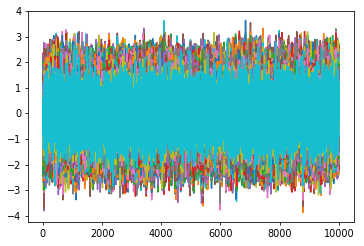

In [7]:
from disorder_model import correlated_noise
from numpy.fft import rfft, irfft, rfftfreq, hfft, ihfft, fftshift

M = int(1e4) # average over this many replications
L = 1001 # system size
x = np.arange(0, L//2 + 1,1)
print(x.shape)

A, B, gamma = [0.26619629, 0.26956846, 0.62552483]
f = lambda x, A, B, gamma: A*(1+x**2)**(-gamma/2) + B
p = f(x, A, B, gamma)

power_law_noise, U, Uq, Sq, Nq = correlated_noise(p, replications = M)
plt.plot(power_law_noise);

mean(binary) = -0.005327929012537238
std(binary) = 0.7322264126237368
mean(noise) = -0.005327929012537238
std(noise) = 0.7322264126237368


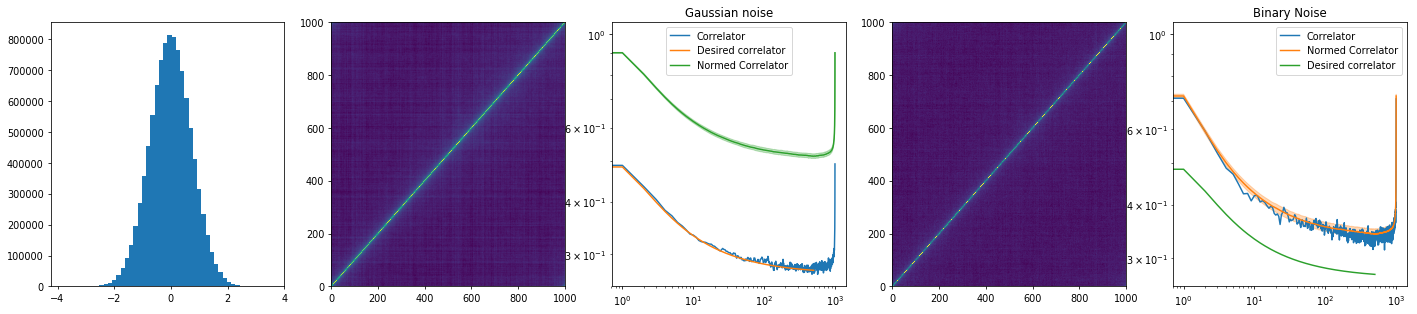

In [8]:
alternating = 2*(np.arange(power_law_noise.shape[-1]) % 2) - 1
alternating_power_law_noise = power_law_noise * alternating

binary = 2*(power_law_noise > 0) - 1
print(f'mean(binary) = {power_law_noise.mean()}')
print(f'std(binary) = {power_law_noise.std()}')

print(f'mean(noise) = {power_law_noise.mean()}')
print(f'std(noise) = {power_law_noise.std()}')

C = np.cov(power_law_noise, rowvar = False)
R = diag2column(np.corrcoef(power_law_noise, rowvar = False))

Cb = np.cov(binary, rowvar = False)
Rb = diag2column(np.corrcoef(binary, rowvar = False))

f, axes = plt.subplots(1,5, figsize = (25,5))   
    
axes[0].hist(power_law_noise.flatten(), bins = 50)

axes[1].pcolormesh(C.T)

axes[2].set(title = 'Gaussian noise')
axes[2].loglog(C[0, : ], label = 'Correlator')
axes[2].plot(p[:], label = 'Desired correlator')
spread(axes[2], range(R.shape[0]), R.mean(axis = 0), R.std(axis = 0), label = 'Normed Correlator')

axes[3].pcolormesh(Cb.T)

axes[4].set(title = 'Binary Noise')
axes[4].loglog(Cb[0, : ], label = 'Correlator')
spread(axes[4], range(Rb.shape[0]), Rb.mean(axis = 0), Rb.std(axis = 0), label = 'Normed Correlator')
axes[4].plot(p[:], label = 'Desired correlator')


axes[2].legend()
axes[4].legend()